### Notebook to genereate binned cross sections from TC output

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
4/23/22

In [123]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt
import subprocess
import sys
from thermo_functions import theta_virtual, relh
from mask_tc_track import mask_tc_track

#### Main settings

In [124]:
# Index variable
ivar_select = 'pw'
# options: pw, vmf, rain, lwacre

# Fill variable
fillvar_select = 'avor'
# options: avor, lwcrf, tprm, dbz, rh

istrat=2 # 0-non-raining, 1-conv, 2-strat, 3-other/anvil, (-1 for off)

# Number of sample time steps
nt=6

#### Directories and additional settings

In [125]:
storm = 'haiyan'

main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'

# Time selection
hr_tag = str(np.char.zfill(str(nt), 2))

# Tests to read and compare
tests = ['ctl','ncrf']
# tests = ['crfon','ncrf']

# Members
nmem = 1#5 # number of ensemble members (1-5 have NCRF)
# Starting member to read
memb0=1

# Shift starting-read time step for CRFON comparison
t0_test=0
if tests[0] == 'crfon':
    t0_test=24
    memb0=5 # for CRFFON test

# TC tracking
ptrack='600' # tracking pressure level
var_track = 'rvor' # variable
rmax = 6 # radius (deg) limit for masking around TC center

nums=np.arange(memb0,nmem+memb0,1); nums=nums.astype(str)
nustr = np.char.zfill(nums, 2)
memb_all=np.char.add('memb_',nustr)

# Strat/Conv index subset
if istrat == -1:
    fig_extra=''
else:
    if istrat == 0:
        strattag='Nonrain'
    elif istrat == 1:
        strattag='Conv'
    elif istrat == 2:
        strattag='Strat'
    elif istrat == 3:
        strattag='Anv'
    fig_extra='_'+strattag.lower()

#### NetCDF variable read functions

In [126]:
def var_read_3d(datdir,varname,t0,t1):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][t0:t1,:,:,:]
    varfil_main.close()
    return var
def var_read_2d(datdir,varname,t0,t1):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][t0:t1,:,:,:]
    varfil_main.close()
    return var

#### Index variable settings

In [127]:
# Index AKA Bin variable settings

# PW
if ivar_select == 'pw':
    fmin=35;fmax=80 # mm
    step=1
    bins=np.arange(fmin,fmax+step,step)
    xlabel='Column water vapor [mm]'
    log_x='linear'
# Rainfall rate
elif ivar_select == 'rain':
    bins=10.**(np.arange(1,8,0.3)-4)
    bins=10.**(np.arange(0,8,0.3)-4)
    xlabel='Rainfall rate [mm/hr]'
    log_x='log'
# Vertical mass flux
elif ivar_select == 'vmf':
    bins=10.**(np.arange(1,8,0.3)-3)
    # bins=np.flip(-1.*bins)
    xlabel='Vertical mass flux [kg/m/s]'
    log_x='log'
# LW-ACRE
elif ivar_select == 'lwacre':
    fmin=-50; fmax=200 # W/m2
    step=5
    bins=np.arange(fmin,fmax+step,step)
    xlabel='LW-ACRE [W/m**2]'
    log_x='linear'

nbins = np.size(bins)

# Create axis of bin center-points for plotting
bin_axis = (bins[np.arange(nbins-1)]+bins[np.arange(nbins-1)+1])/2

#### Main loops and compositing

In [128]:
# #### Directories

nums=np.arange(memb0,nmem+memb0,1); nums=nums.astype(str)
nustr = np.char.zfill(nums, 2)
memb_all=np.char.add('memb_',nustr)

datdir2 = 'post/d02/'

##### Get dimensions

datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'+datdir2
datdir3d = datdir+'v2/'
varfil_main = Dataset(datdir3d+'T.nc')
nz = varfil_main.dimensions['level'].size
# lat = varfil_main.variables['XLAT'][:][0] # deg
# lon = varfil_main.variables['XLONG'][:][0] # deg
nx1 = varfil_main.dimensions['lat'].size
nx2 = varfil_main.dimensions['lon'].size
pres = varfil_main.variables['pres'][:] # hPa
dp = (pres[1]-pres[0])*1e2 # Pa
varfil_main.close()

process = subprocess.Popen(['ls '+main+storm+'/'+memb_all[0]+'/'+tests[0]+'/wrfout_d02_*'],shell=True,
    stdout=subprocess.PIPE,universal_newlines=True)
output = process.stdout.readline()
wrffil = output.strip() #[3]
varfil_main = Dataset(wrffil)
lat = varfil_main.variables['XLAT'][:][0] # deg
lon = varfil_main.variables['XLONG'][:][0] # deg
varfil_main.close()

# Loop over sensitivity tests

ntest=2
var_binned=np.ma.zeros((ntest,nbins-1,nz))
cvar_binned=np.ma.zeros((ntest,nbins-1,nz))
strat_binned=np.ma.zeros((ntest,nbins-1,4)) # 0-non-raining, 1-conv, 2-strat, 3-other/anvil
var_mn=np.ma.zeros((ntest,nz))

for ktest in range(ntest):

    test_str=tests[ktest]

    # This has been tested for corresponding time steps:
    #   t0=37,1 are the first divergent time steps in CTL,NCRF
    #   t0=25,1 are the first divergent time steps in NCRF,CRFON
    if test_str == 'ctl':
        t0=36
    elif test_str == 'ncrf':
        t0=t0_test
    elif test_str == 'crfon':
        t0=0

    t0+=1 # add one time step since NCRF(t=0) = CTL
    t1 = t0+nt

    print('Running test: ',test_str)

    # Create arrays to save ens members
    var_all = np.ma.zeros((nmem,nt,nz,nx1,nx2))
    cvar_all = np.ma.zeros((nmem,nt,nz,nx1,nx2))
    ivar_all = np.ma.zeros((nmem,nt,nx1,nx2))
    strat_all = np.ma.zeros((nmem,nt,nx1,nx2))

    # Loop over ensemble members

    for imemb in range(nmem):
    
        print('Running imemb: ',memb_all[imemb])
    
        datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2
        datdir3d = datdir+'v2/'
        print(datdir)

        # Localize to TC track
        track_file = datdir+'../../track_'+var_track+'_'+ptrack+'hPa.nc'


        # Required variables

        # Stratiform index
        # if istrat != -1:
        varname = 'strat'
        strat = var_read_2d(datdir,varname,t0,t1) # 0-non-raining, 1-conv, 2-strat, 3-other/anvil

        # Rain
        varname = 'rainrate'
        rain = var_read_2d(datdir,varname,t0,t1) # mm/hr

        # Line contour variable ("cvar")
        # Vertical motion
        varname='W'
        w = var_read_3d(datdir3d,varname,t0,t1) # m/s
        cvar = w*1e2 # m/s --> cm/s
        units_var2='cm/s'
        lcmin = -20; lcmax=20; lcint=2


        # Index AKA Bin variable ("ivar")

        # PW
        if ivar_select == 'pw':
            varname = ivar_select.upper()
            ivar = var_read_2d(datdir,varname,t0,t1)
        # Rainfall rate
        elif ivar_select == 'rain':
            ivar = rain # mm/hr
        # Vertical mass flux
        elif ivar_select == 'vmf':
            g=9.81 # gravity, m/s2
            wv_int = np.sum(w,axis=1) * dp/g # m/s * s**2/m * kg/m/s**2 = kg/s/m
            ivar = np.reshape(wv_int,(nt,1,nx1,nx2))
        # LW-ACRE
        elif ivar_select == 'lwacre':
            binfil = Dataset(datdir+'LWacre.nc') # this opens the netcdf file
            ivar = binfil.variables['LWUPB'][t0:t1,:,:,:] # W/m2
            binfil.close()


        # Three-dimensional dependent variables ("var")

        # Radar Reflectivity
        if fillvar_select == 'dbz':
            varname = fillvar_select
            var = var_read_3d(datdir3d,varname,t0,t1)
        # Radiation
        elif fillvar_select == 'lwcrf':
            varname = 'RTHRATLW'
            var = var_read_3d(datdir3d,varname,t0,t1) * 3600.*24 # K/s --> K/d
            varname = 'RTHRATLWC'
            var -= var_read_3d(datdir3d,varname,t0,t1) * 3600.*24 # K/s --> K/d
        # Horizontal temperature anomaly
        elif fillvar_select == 'tprm':
            varname = 'T'
            tmpk = var_read_3d(datdir3d,varname,t0,t1) # K
            varname = 'QVAPOR'
            qv = var_read_3d(datdir3d,varname,t0,t1) # kg/kg
            var = theta_virtual(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # K
            # Subtract time-dependent domain average
            radius_ls = 12 # deg
            var_ls = mask_tc_track(track_file, radius_ls, var, lon, lat, t0, t1)
            var_ls_avg = np.ma.mean(var_ls,axis=(0,2,3))
            var -= var_ls_avg[np.newaxis,:,np.newaxis,np.newaxis]
        # Relative humidity
        elif fillvar_select == 'rh':
            varname = 'T'
            tmpk = var_read_3d(datdir3d,varname,t0,t1) # K
            varname = 'QVAPOR'
            qv = var_read_3d(datdir3d,varname,t0,t1) # kg/kg
            var = relh(qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2,tmpk,ice=1) # RH in %
        # Absolute vorticity
        elif fillvar_select == 'avor':
            varname = 'AVOR'
            var = var_read_3d(datdir3d,varname,t0,t1) # 10^-5 /s
            var*=10 # --> 10^/6 /s


        ### Process variable ##############################################

        # Mask out based on strat/conv
        if istrat != -1:
            var = np.ma.masked_where((np.repeat(strat,nz,axis=1) != istrat), var, copy=True)
            cvar = np.ma.masked_where((np.repeat(strat,nz,axis=1) != istrat), cvar, copy=True)
            ivar = np.ma.masked_where((strat != istrat), ivar, copy=True)

        # Localize to TC track
        var = mask_tc_track(track_file, rmax, var, lon, lat, t0, t1)
        cvar = mask_tc_track(track_file, rmax, cvar, lon, lat, t0, t1)
        ivar = mask_tc_track(track_file, rmax, ivar, lon, lat, t0, t1)
        strat = mask_tc_track(track_file, rmax, strat, lon, lat, t0, t1)

        # Save ens member
        var_all[imemb,:,:,:,:]  = var
        cvar_all[imemb,:,:,:,:] = cvar
        ivar_all[imemb,:,:,:]   = ivar[:,0,:,:]
        strat_all[imemb,:,:,:]  = strat[:,0,:,:]

        #### Calculate basic mean
        var_mn[ktest,:]=np.ma.mean(var_all,axis=(0,1,3,4))
    
    
    # Bin the variables, averaging across member, time, x, y: (nmemb,nt,nz,nx1,nx2) --> (nbins,nz)
    for ibin in range(nbins-1):
        
        indices = ((ivar_all >= bins[ibin]) & (ivar_all < bins[ibin+1])).nonzero()
        
        for kstrat in range(0,4):
            indices_strat = (strat_all[indices] == kstrat).nonzero()
            strat_binned[ktest,ibin,kstrat] = indices_strat[0].shape[0]
        
        if indices[0].shape[0] > 3:
            var_binned[ktest,ibin,:]  = np.mean(var_all[ indices[0],indices[1],:,indices[2],indices[3]], axis=0, dtype=np.float64)
            cvar_binned[ktest,ibin,:] = np.mean(cvar_all[indices[0],indices[1],:,indices[2],indices[3]], axis=0, dtype=np.float64)
        else:
            var_binned[ktest,ibin,:] = np.nan
            cvar_binned[ktest,ibin,:] = np.nan

Running test:  ctl
Running imemb:  memb_01
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/haiyan/memb_01/ctl/post/d02/
Running test:  ncrf
Running imemb:  memb_01
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/haiyan/memb_01/ncrf/post/d02/


#### New conv/strat index

In [129]:
# strat2 = stratiform_index(rain,vmf_lower,vmf_upper,verbose=1)

---
### Plotting routines

In [130]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

### Figure settings

In [131]:
# Three-dimensional dependent variables ("var")

# Radar Reflectivity
if fillvar_select == 'dbz':
    title = 'Ref'
    units_var1 = 'dBZ'
    cmin = -20; cmax=20
    cmap='RdBu_r'
# Radiation
elif fillvar_select == 'lwcrf':
    title = 'LW-CRF'
    figtag = fillvar_select
    cmap='RdBu_r'
    units_var1 = 'K/d'
    cmax=4; cmin=-1.*cmax
# Horizontal temperature anomaly
elif fillvar_select == 'tprm':
    title = r"$\theta_v'$"
    figtag = 'thprm'
    units_var1 = 'K'
    # cmax=1; cmin=-1.*cmax
    cmap='RdBu_r'
    cmax=2; cmin=-1.*cmax
    cmax_diff=.4; cmin_diff=-1.*cmax_diff
# Relative humidity
elif fillvar_select == 'rh':
    title = "RH"
    figtag = fillvar_select
    units_var1 = '%'
    cmap='RdBu_r'
    cmax=100; cmin=20
    cmax_diff=2; cmin_diff=-1*cmax_diff
# Absolute vorticity
elif fillvar_select == 'avor':
    title = "AVor"
    figtag = fillvar_select
    cmap='GnBu'
    units_var1 = '10$^{-6}$ /s'
    cmax=100; cmin=20
    cmax_diff=100; cmin_diff=-1*cmax_diff

### Main Cross Section

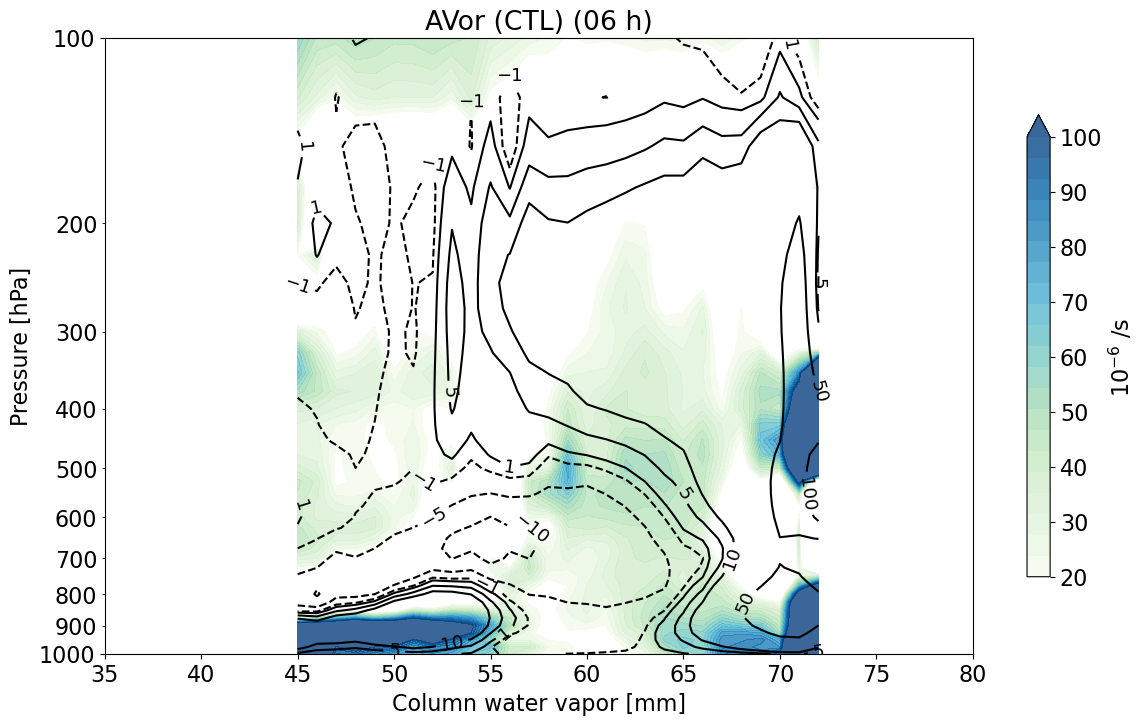

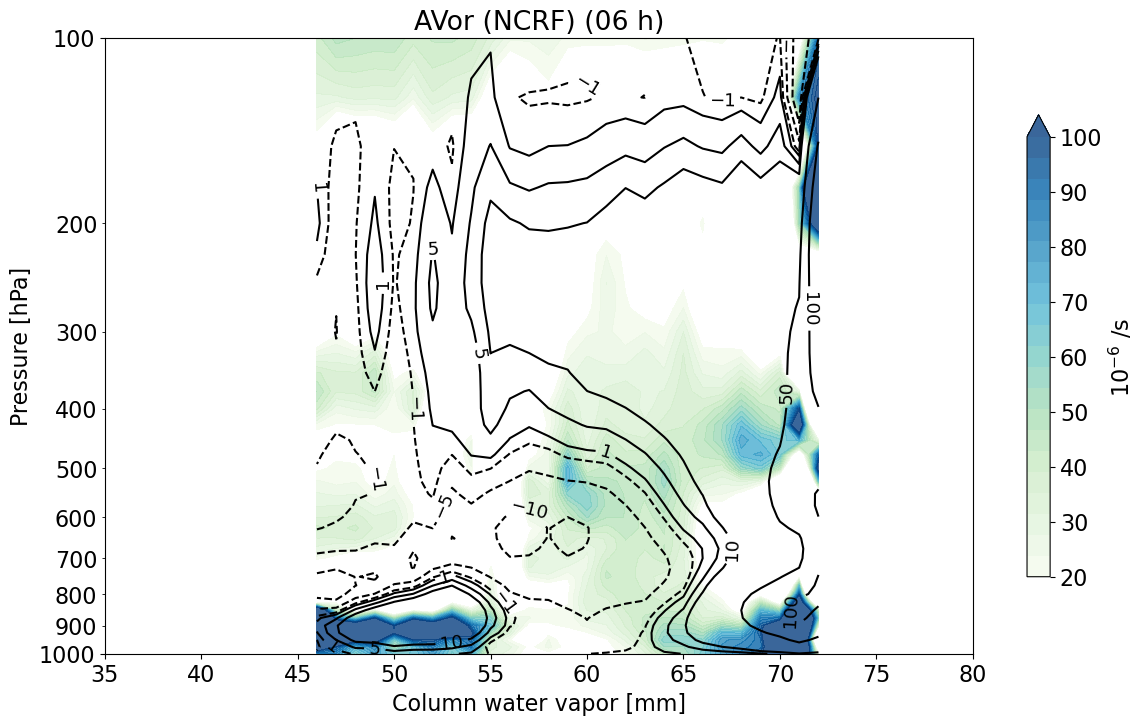

In [132]:
# Loop over sensitivity tests
for ktest in range(ntest):

    test_str=tests[ktest].upper()
    fig_title = title+' ('+test_str.upper()+') ('+hr_tag+' h)'
    
    # create figure
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(111)

    ax.set_title(fig_title)
    ax.set_ylabel('Pressure [hPa]')

    pltvar=var_binned[ktest,:,:]
    cpltvar=cvar_binned[ktest,:,:]

    # fill contour
    nlevs=21
    inc=(cmax-cmin)/nlevs
    clevs = np.arange(cmin, cmax+inc, inc)
    im = ax.contourf(bins[0:nbins-1], pres, np.transpose(pltvar), clevs, cmap=cmap, alpha=0.8, \
                    extend='max', zorder=2)

    cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
    cbar.ax.set_ylabel(units_var1)
    
    plt.ylim(100,np.max(pres))
    ax.invert_yaxis()
    ax.set_yscale('log')
    ax.set_xscale(log_x)
    ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

    ax.set_xlabel(xlabel)
    plt.xlim(np.min(bins), np.max(bins))

    # ax2=ax.twinx()
    # im = ax.plot(bins[0:nbins-1], binvar_s_mn)

    # line contour
    # clevs = np.arange(lcmin, lcmax, lcint)
    # clevs = [0.1,0.5,1,2,5,10,50,100,500,1000,2000,3000]
    clevs = [1,5,10,50,100,500,1000,2000,3000]
    clevs = np.concatenate((-1*np.flip(clevs),clevs))
    # cpltvar=np.gradient(binvar_c_mn,10000,axis=1,edge_order=2)*-1e5
    im = ax.contour(bins[0:nbins-1], pres, np.transpose(cpltvar), clevs, colors='black', zorder=2)
    ax.clabel(im, im.levels, inline=True, fontsize=13)

    # plt.savefig(figdir+figtag+'_compcross_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
    #             bbox_inches='tight', pad_inches=0.2)
    plt.show()
    plt.close()

### Difference between sensitivity tests

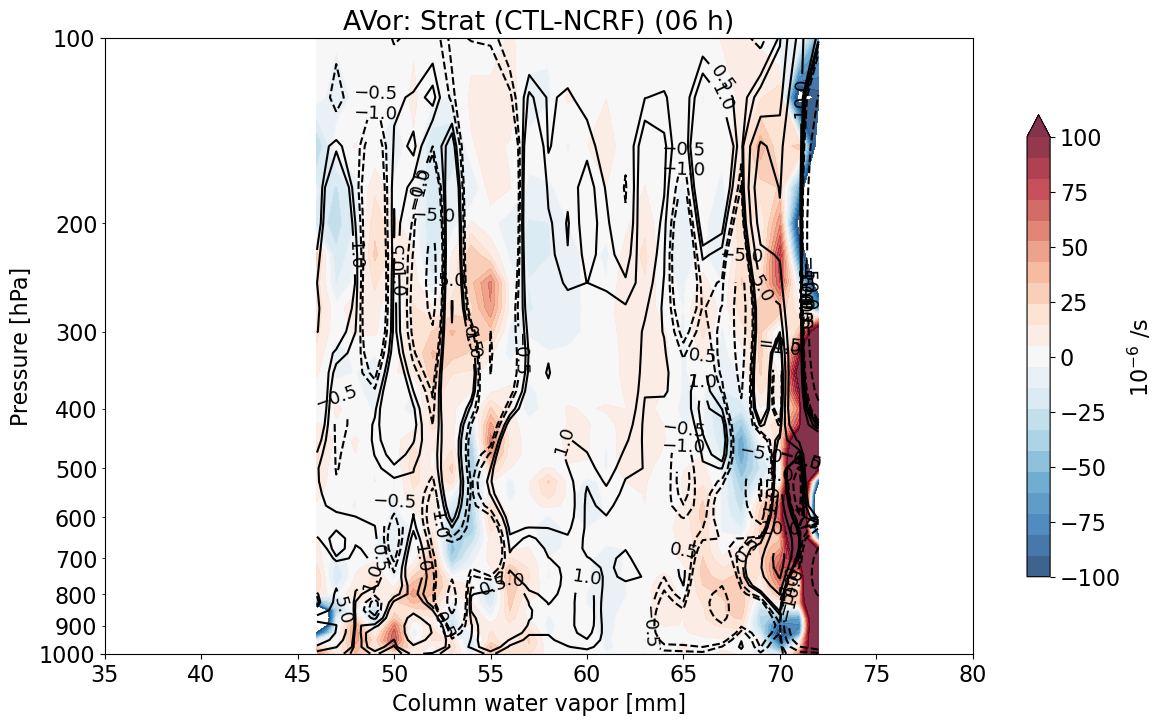

In [133]:
# Difference between sensitivity tests

if istrat == -1:
    fig_title = title+' ('+tests[0].upper()+'-'+tests[1].upper()+') ('+hr_tag+' h)'
else:
    fig_title = title+': '+strattag+' ('+tests[0].upper()+'-'+tests[1].upper()+') ('+hr_tag+' h)'

# create figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.set_title(fig_title)
ax.set_ylabel('Pressure [hPa]')

pltvar =  var_binned[0,:,:] - var_binned[1,:,:]
cpltvar = cvar_binned[0,:,:]  - cvar_binned[1,:,:]

# fill contour
nlevs=21
inc=(cmax_diff-cmin_diff)/nlevs
clevs = np.arange(cmin_diff, cmax_diff+inc, inc)
im = ax.contourf(bins[0:nbins-1], pres, np.transpose(pltvar), clevs, cmap='RdBu_r', alpha=0.8, \
                extend='max', zorder=2)

cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
cbar.ax.set_ylabel(units_var1)

plt.ylim(100,np.max(pres))
ax.invert_yaxis()
ax.set_yscale('log')
ax.set_xscale(log_x)
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_xlabel(xlabel)
plt.xlim(np.min(bins), np.max(bins))

# ax2=ax.twinx()
# im = ax.plot(bins[0:nbins-1], binvar_s_mn)

# line contour
# clevs = np.arange(lcmin, lcmax, lcint)
# clevs = [0.1,0.5,1,2,5,10,50,100,500,1000,2000,3000]
clevs = [0.2,0.5,1,2]
clevs = [.5,1,5,10,50]
clevs = np.concatenate((-1*np.flip(clevs),clevs))
# cpltvar=np.gradient(binvar_c_mn,10000,axis=1,edge_order=2)*-1e5
im = ax.contour(bins[0:nbins-1], pres, np.transpose(cpltvar), clevs, colors='black', zorder=2)
ax.clabel(im, im.levels, inline=True, fontsize=13)

figtag2 = figtag+'_'+ivar_select+fig_extra
plt.savefig(figdir+'binnedcross_'+figtag2+'_diff_'+hr_tag+'.png',dpi=200, facecolor='white', \
            bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()

### Conv/Strat Area

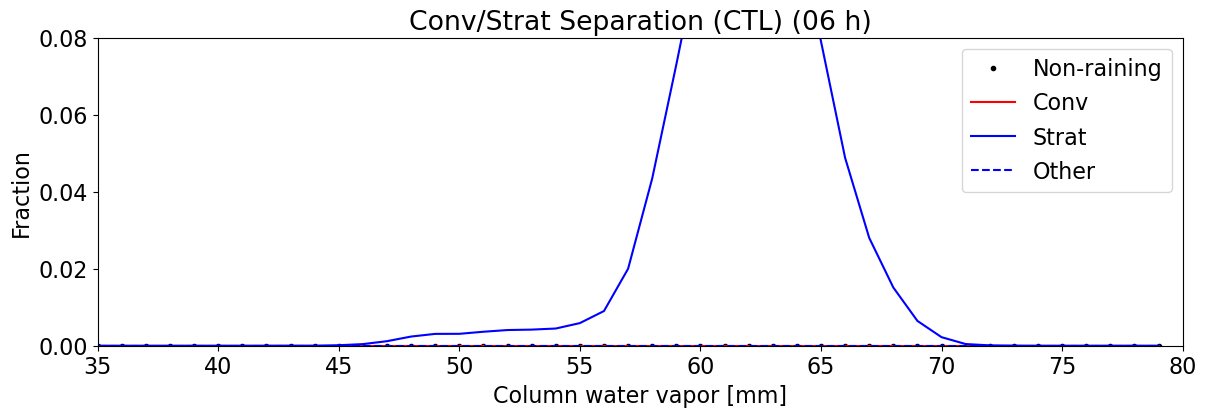

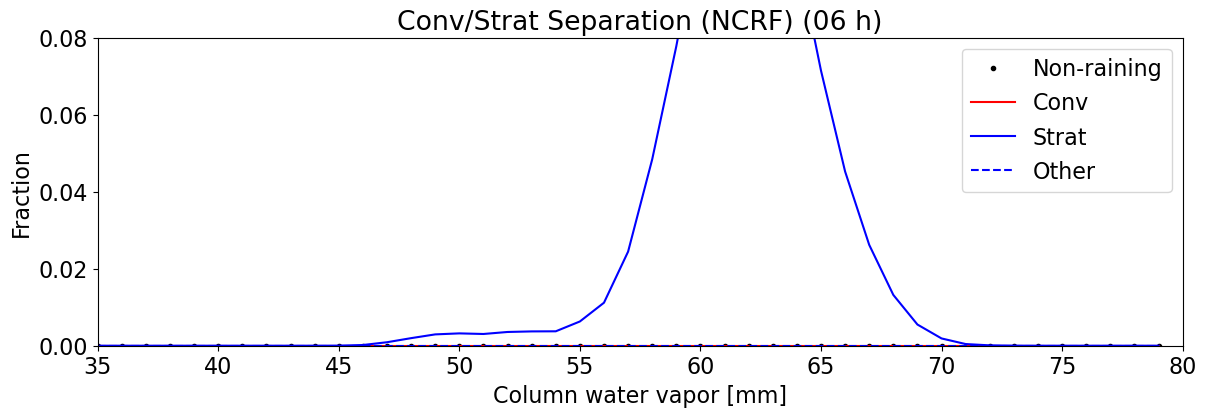

In [134]:
# Loop over sensitivity tests
for ktest in range(ntest):

    test_str=tests[ktest].upper()
    fig_title = 'Conv/Strat Separation ('+test_str.upper()+') ('+hr_tag+' h)'
    
    # create figure
    fig = plt.figure(figsize=(14,4))
    ax = fig.add_subplot(111)

    ax.set_title(fig_title)
    ax.set_xlabel(xlabel)
    ax.set_xscale(log_x)

    # Conv/strat separation: varout = 1 if convective, = 2 if stratiform, = 3 other, = 0 if no rain

    # As fraction of all-points-total
    ax.set_ylabel('Fraction')
    total=np.sum(strat_binned[ktest,:,:])

    plt.plot(bins[0:nbins-1], strat_binned[ktest,:,0]/total \
            , ".k", label="Non-raining")
    plt.plot(bins[0:nbins-1], strat_binned[ktest,:,1]/total \
            , "-r", label="Conv")
    plt.plot(bins[0:nbins-1], strat_binned[ktest,:,2]/total \
            , "-b", label="Strat")
    plt.plot(bins[0:nbins-1], strat_binned[ktest,:,3]/total \
            , "--b", label="Other")

    plt.xlim(np.min(bins), np.max(bins))
    plt.ylim(0, 0.08)

    plt.legend(loc="upper right")

    # plt.savefig(figdir+'convstrat_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
    #             bbox_inches='tight', pad_inches=0.2)
    plt.show()
    plt.close()

### Difference between sensitivity tests

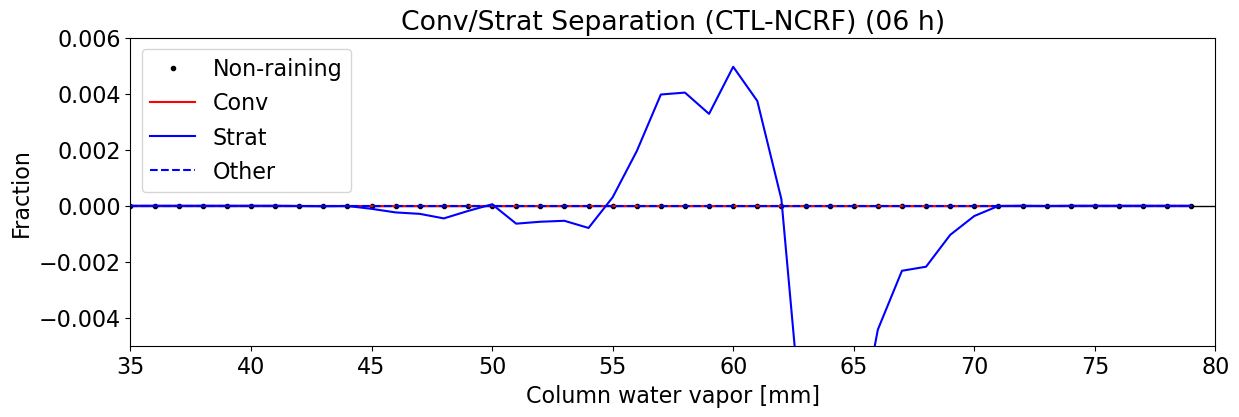

In [135]:
# Loop over sensitivity tests

fig_title = 'Conv/Strat Separation ('+tests[0].upper()+'-'+tests[1].upper()+') ('+hr_tag+' h)'

# create figure
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)

ax.set_title(fig_title)
ax.set_xlabel(xlabel)
ax.set_xscale(log_x)

# Conv/strat separation: varout = 1 if convective, = 2 if stratiform, = 3 other, = 0 if no rain

strat_var = strat_binned[1,:,:] - strat_binned[0,:,:]

# As fraction of all-points-total
ax.set_ylabel('Fraction')
total=np.sum(strat_binned[0,:,:])

plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth=1)

plt.plot(bins[0:nbins-1], strat_var[:,0]/total \
        , ".k", label="Non-raining")
plt.plot(bins[0:nbins-1], strat_var[:,1]/total \
        , "-r", label="Conv")
plt.plot(bins[0:nbins-1], strat_var[:,2]/total \
        , "-b", label="Strat")
plt.plot(bins[0:nbins-1], strat_var[:,3]/total \
        , "--b", label="Other")

plt.xlim(np.min(bins), np.max(bins))
plt.ylim(-0.005, 0.006)

plt.legend(loc="upper left")

# plt.savefig(figdir+'convstrat_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()

### VMF

In [136]:
# # create figure
# fig = plt.figure(figsize=(14,4))
# ax = fig.add_subplot(111)

# ax.set_title('Vertical mass flux')
# ax.set_xlabel(xlabel)
# ax.set_xscale(log_x)

# # ax.set_ylabel('kg/m/s')
# # plt.plot(bins[0:nbins-1], binvar_vmfl_mn, "-k", label="Lower")
# # plt.plot(bins[0:nbins-1], binvar_vmfh_mn, "--k", label="Upper")
# ax.set_ylabel('%')
# plt.plot(bins[0:nbins-1], binvar_vmfth_mn, "-k", label="TH index")

# plt.xlim(np.min(bins), np.max(bins))
# # plt.ylim(0, 0.2)
# # ax.set_yscale('log')

# plt.legend(loc="upper left")


# plt.show()
# # plt.savefig(figdir+'convstrat_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
# #             bbox_inches='tight', pad_inches=0.2)

### Test of vertical mode decomposition

In [137]:
# # A specific, known sinusoidal function
# nlevs=100
# nharmonic = 5
# scale = [3.,9,15,25,50,100]
# # scale = np.ones(nharmonic)
# zind=np.arange(0,1,1./nlevs)
# fx = np.zeros(nlevs)
# for nk in range(nharmonic):
#     fx += np.sin(2*np.pi*(nk+1)*zind) * scale[nk]
#     # print(np.sin(2*np.pi*(nk+1)*zind))


# an = np.zeros(nharmonic)
# bn = np.zeros(nharmonic)
# for nk in range(nharmonic):
#     # print("k = ",nk+1)
#     kx = 2*np.pi * (nk+1) * zind
#     # print("kx = ",kx)
#     an[nk] = (2./nlevs) * np.sum( fx * np.cos(kx) )
#     bn[nk] = (2./nlevs) * np.sum( fx * np.sin(kx) )

# # # power=np.sqrt(an**2 + bn**2)
# power=an + bn
# # power=np.abs(power)
# # print(an)
# print(power)

# # create figure
# fig = plt.figure(figsize=(5,4))
# ax = fig.add_subplot(111)
# ax.set_title('Sine function')
# ax.set_ylabel('z/H')

# plt.plot(fx, zind)

# plt.show()

### LW ACRE

In [138]:
# # create figure
# fig = plt.figure(figsize=(14,4))
# ax = fig.add_subplot(111)

# ax.set_title('LW-ACRE')
# ax.set_xlabel(xlabel)
# ax.set_xscale(log_x)

# pltvar=binvar_acre_mn

# ax.set_ylabel('ACRE [W/m**2]')
# plt.plot(bins[0:nbins-1], pltvar)

# # plt.ylim(0, 0.2)
# plt.xlim(np.min(bins), np.max(bins))

# # plt.legend(loc="upper left")

# plt.show()
# # plt.savefig(figdir+'lwacre_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
# #             bbox_inches='tight', pad_inches=0.2)

### LW ACRE Scaled by Area

In [139]:
# # create figure
# fig = plt.figure(figsize=(14,4))
# ax = fig.add_subplot(111)

# ax.set_title('LW-ACRE * Rain Fraction')
# ax.set_xlabel(xlabel)
# ax.set_xscale(log_x)

# # As fraction of all-rain-total
# ax.set_ylabel('LW-ACRE * Fraction')
# total=np.sum(binvar_s_mn[:,(1,2,3)])
# plt.plot(bins[0:nbins-1], binvar_acre_mn*binvar_s_mn[:,0]/total \
#          , ".k", label="Non-raining")
# plt.plot(bins[0:nbins-1], binvar_acre_mn*binvar_s_mn[:,1]/total \
#          , "-r", label="Conv")
# plt.plot(bins[0:nbins-1], binvar_acre_mn*binvar_s_mn[:,2]/total \
#          , "-b", label="Strat")
# plt.plot(bins[0:nbins-1], binvar_acre_mn*binvar_s_mn[:,3]/total \
#          , "--b", label="Other")

# plt.xlim(np.min(bins), np.max(bins))
# plt.ylim(0, 10)

# plt.legend(loc="upper left")

# plt.show()
# # plt.savefig(figdir+'lwacrescaled_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
# #             bbox_inches='tight', pad_inches=0.2)